<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

In [3]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [4]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [5]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    int64  
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 49.3 KB


In [6]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [7]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608        1
1   27   1      10        6      31     17.3   1.362202  4.000798        0
2   40   1      15       14      55      5.5   0.856075  2.168925        0
3   41   1      15       14     120      2.9   2.658720  0.821280        0
4   24   2       2        0      28     17.3   1.787436  3.056564        1

In [8]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [9]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [10]:
num_summary

N  NMISS           SUM       MEAN     MEDIAN        STD  \
age       700.0    0.0  24402.000000  34.860000  34.000000   7.997342   
ed        700.0    0.0   1206.000000   1.722857   1.000000   0.928206   
employ    700.0    0.0   5872.000000   8.388571   7.000000   6.658039   
address   700.0    0.0   5795.000000   8.278571   7.000000   6.824877   
income    700.0    0.0  31921.000000  45.601429  34.000000  36.814226   
debtinc   700.0    0.0   7182.400000  10.260571   8.600000   6.827234   
creddebt  700.0    0.0   1087.486972   1.553553   0.854869   2.117197   
othdebt   700.0    0.0   2140.746028   3.058209   1.987567   3.287555   
default   700.0    0.0    183.000000   0.261429   0.000000   0.439727   

                  VAR        MIN         P1         P5        P10        P25  \
age         63.957482  20.000000  21.000000  23.000000  25.000000  29.000000   
ed           0.861566   1.000000   1.000000   1.000000   1.000000   1.000000   
employ      44.329483   0.000000   0.000000   0.000000   1.000000   3.000000   
address     46.578939   0.000000   0.000000   0.000000   1.000000   3.000000   
income    1355.287265  14.000000  15.000000  17.000000  19.000000  24.000000   
debtinc     46.611118   0.400000   0.900000   1.900000   2.900000   5.000000   
creddebt     4.482523   0.011696   0.030209   0.107029   0.170020   0.369059   
othdebt     10.808015   0.045584   0.160936   0.376727   0.562232   1.044178   
default      0.193360   0.000000   0.000000   0.000000   0.000000   0.000000   

                P50        P75        P90         P95         P99        MAX  
age       34.000000  40.000000  46.000000   49.000000   53.010000   56.00000  
ed         1.000000   2.000000   3.000000    4.000000    4.000000    5.00000  
employ     7.000000  12.000000  18.000000   21.050000   27.010000   31.00000  
address    7.000000  12.000000  18.000000   22.000000   26.010000   34.00000  
income    34.000000  55.000000  82.000000  113.000000  190.300000  446.00000  
debtinc    8.600000  14.125000  19.610000   23.800000   30.701000   41.30000  
creddebt   0.854869   1.901955   3.621504    5.098264    9.891428   20.56131  
othdebt    1.987567   3.923065   7.036180    9.501648   17.184744   27.03360  
default    0.000000   1.000000   1.000000    1.000000    1.000000    1.00000

In [11]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(bankloans)

In [12]:
#Handling Outliers
def outlier_capping(x):
    x =x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

bankloans=bankloans.apply(lambda x: outlier_capping(x))

In [13]:
#Handling missings 
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans=bankloans.apply(lambda x: Missing_imputation(x))

In [14]:
bankloans.corr()

age        ed    employ   address    income   debtinc  \
age       1.000000  0.016576  0.537417  0.596973  0.521450  0.016926   
ed        0.016576  1.000000 -0.158071  0.055560  0.225395  0.009992   
employ    0.537417 -0.158071  1.000000  0.324859  0.665369 -0.035332   
address   0.596973  0.055560  0.324859  1.000000  0.345067  0.014967   
income    0.521450  0.225395  0.665369  0.345067  1.000000 -0.022541   
debtinc   0.016926  0.009992 -0.035332  0.014967 -0.022541  1.000000   
creddebt  0.308318  0.103012  0.405959  0.215397  0.553114  0.534602   
othdebt   0.348911  0.156523  0.419337  0.234896  0.626787  0.603630   
default  -0.138654  0.118521 -0.287197 -0.165389 -0.099553  0.388556   

          creddebt   othdebt   default  
age       0.308318  0.348911 -0.138654  
ed        0.103012  0.156523  0.118521  
employ    0.405959  0.419337 -0.287197  
address   0.215397  0.234896 -0.165389  
income    0.553114  0.626787 -0.099553  
debtinc   0.534602  0.603630  0.388556  
creddebt  1.000000  0.639984  0.238179  
othdebt   0.639984  1.000000  0.138962  
default   0.238179  0.138962  1.000000

<AxesSubplot:>

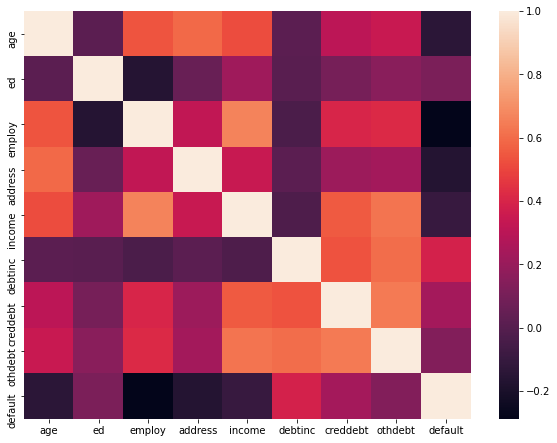

In [15]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans.corr())

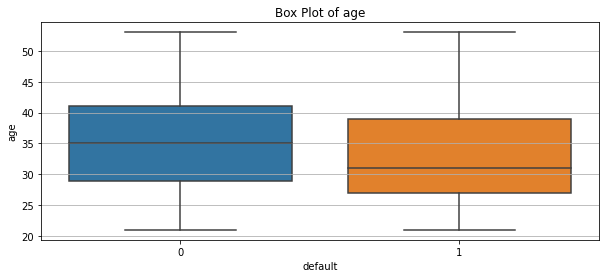

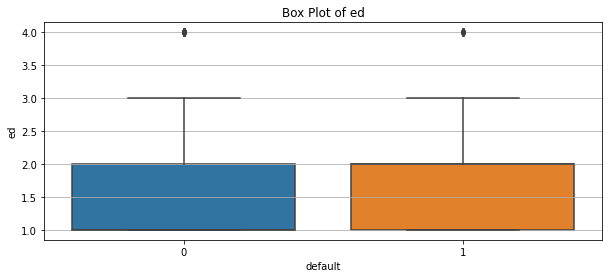

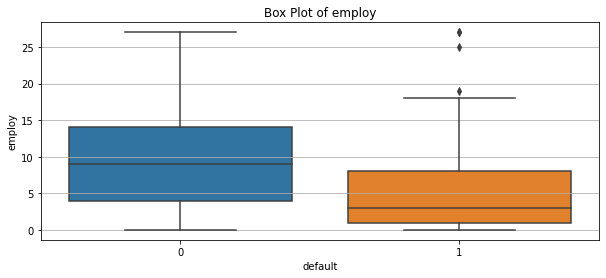

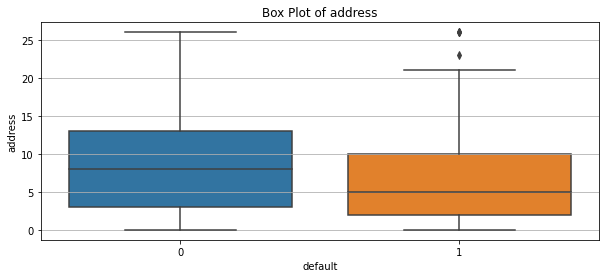

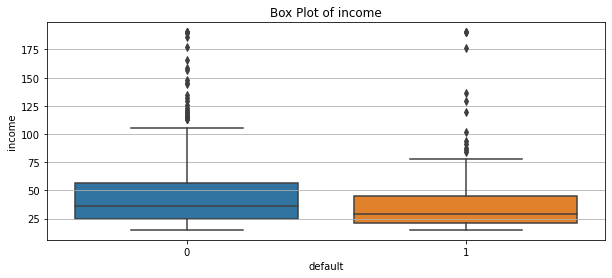

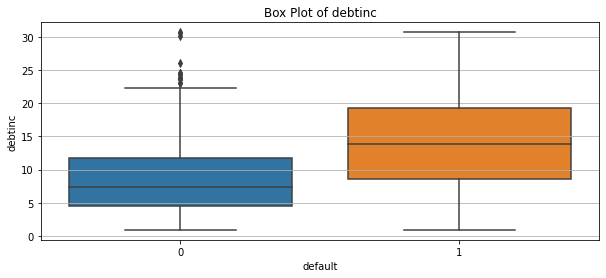

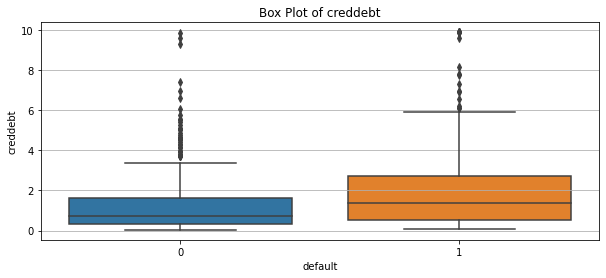

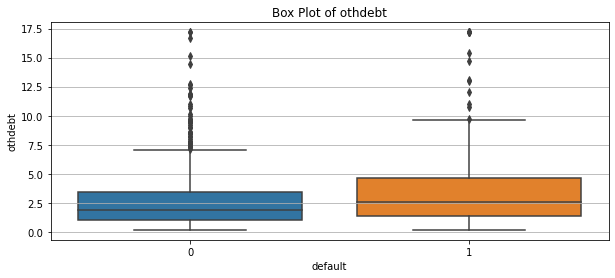

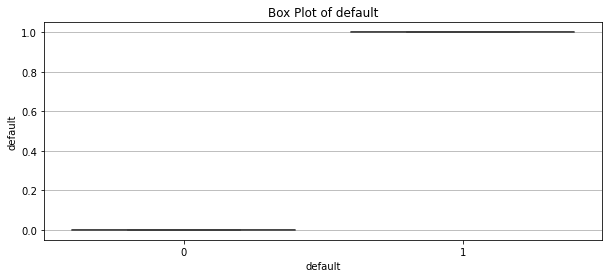

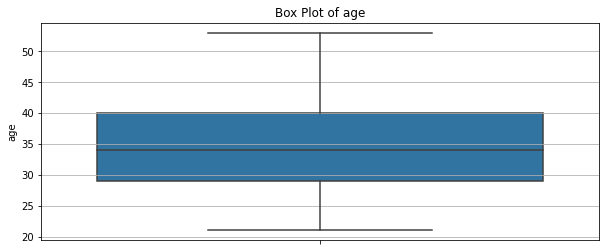

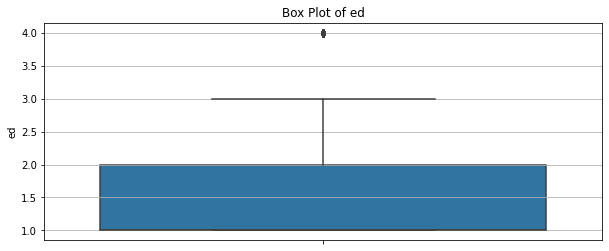

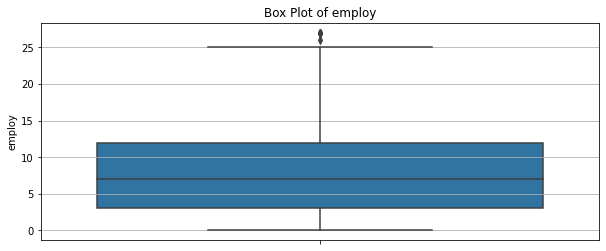

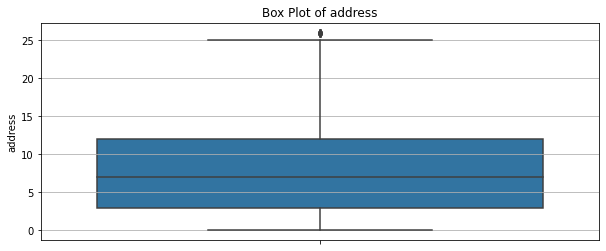

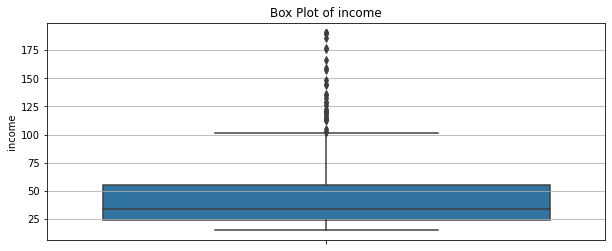

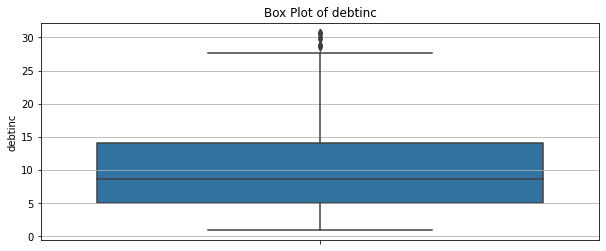

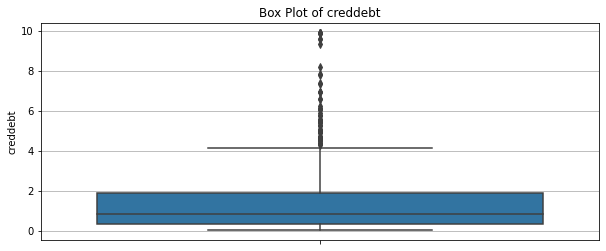

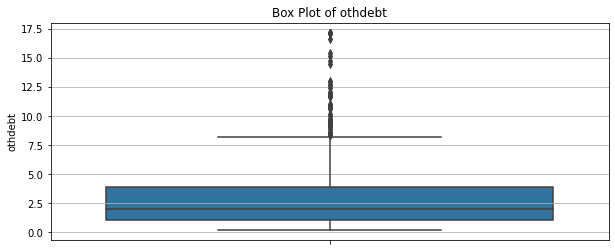

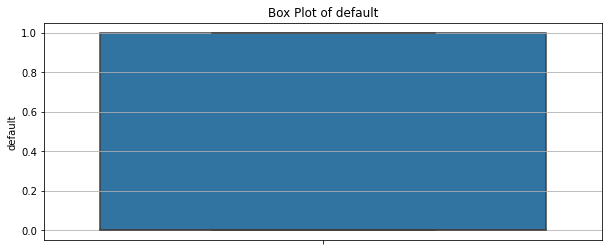

In [16]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

bp = PdfPages('BoxPlots with Total View.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(y=num_variable, data = bankloans)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest/ANOVA) and Categorical(Chisquare)

In [17]:
## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in numeric_var_names:
    tstats = stats.ttest_ind(bankloans[bankloans['default']==1][num_variable],bankloans[bankloans['default']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

  Variable Name T-Statistic      P-Value
0           age    -3.69893  0.000233527
1            ed     3.15351   0.00168236
2        employ    -7.92136  9.27995e-15
3       address    -4.43055  1.09104e-05
4        income    -2.64329   0.00839468
5       debtinc     11.1409  1.20241e-26
6      creddebt     6.47909   1.7428e-10
7       othdebt      3.7073  0.000226095
8       default         inf            0


###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

C:\Users\smirn\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\smirn\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


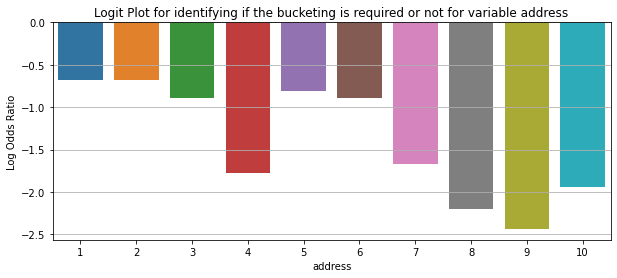

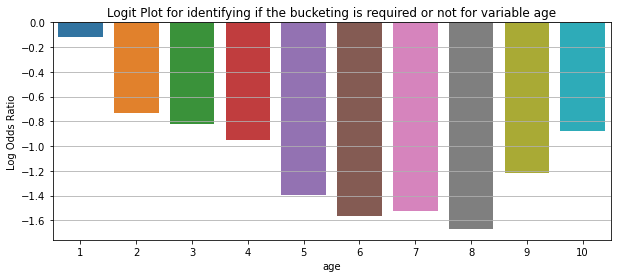

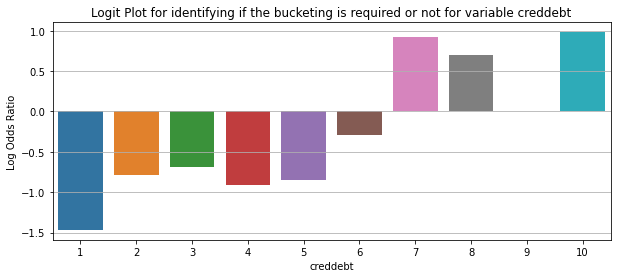

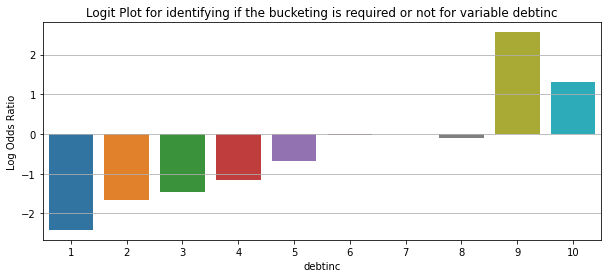

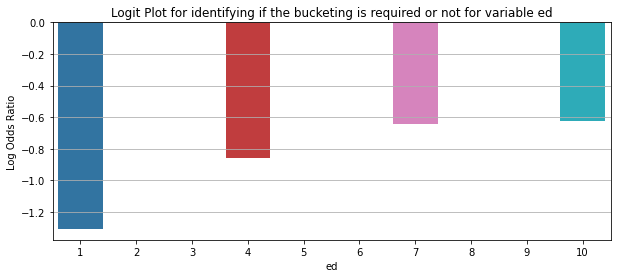

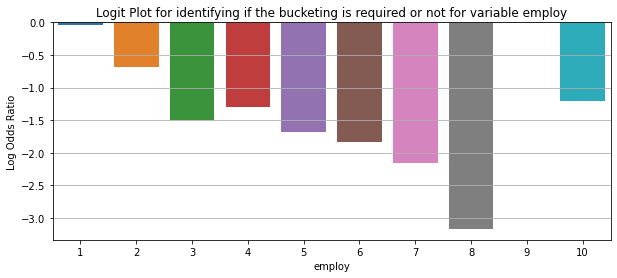

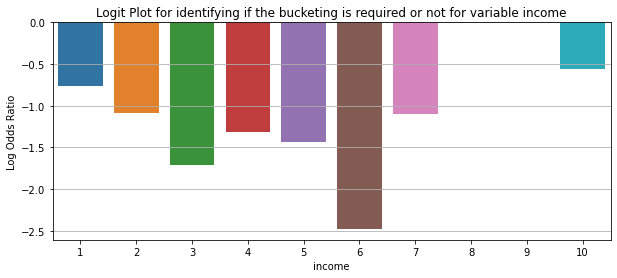

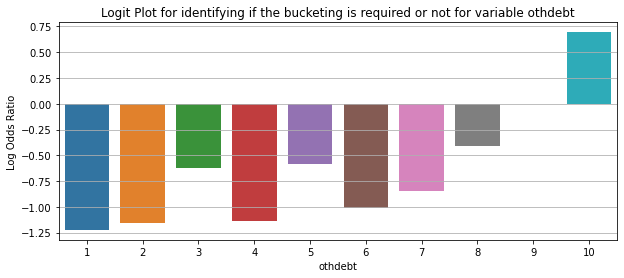

In [18]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans.columns.difference(['default']):
    binned = pd.cut(bankloans[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans.groupby(binned)['default'].sum() / (bankloans.groupby(binned)['default'].count()-bankloans.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [19]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
bankloans.columns

These variables need bucketing - creddebt, othdebt, debtinc, employ, income 


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [20]:
bankloans[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

count       mean        std        min        10%        20%  \
creddebt  700.0   1.498843   1.788451   0.030209   0.170020   0.301390   
othdebt   700.0   3.027290   3.115401   0.160936   0.562232   0.900747   
debtinc   700.0  10.222153   6.682160   0.900000   2.900000   4.500000   
employ    700.0   8.358671   6.566008   0.000000   1.000000   2.000000   
income    700.0  44.848714  31.942133  15.000000  19.000000  22.000000   

                30%        40%        50%        60%        70%        80%  \
creddebt   0.440418   0.593059   0.854869   1.183471   1.615023   2.288026   
othdebt    1.165766   1.546101   1.987567   2.511054   3.258777   4.577926   
debtinc    5.800000   7.000000   8.600000  10.500000  12.900000  15.440000   
employ     4.000000   5.600000   7.000000   9.000000  11.000000  14.000000   
income    26.000000  29.000000  34.000000  40.400000  49.000000  61.000000   

                90%         max  
creddebt   3.621504    9.891428  
othdebt    7.036180   17.184744  
debtinc   19.610000   30.701000  
employ    18.000000   27.010000  
income    82.000000  190.300000

In [21]:
#bucekting
#bankloans_existing['creddebt_extreme'] = bankloans_existing['creddebt'].apply(lambda x: 0 if 162 < x < 221 else 1)
#bankloans_existing['othdebt_extreme'] = bankloans_existing['othdebt'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'] = bankloans_existing['debtinc'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
#bankloans_existing['debtinc_extreme'].value_counts()

###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [22]:

somersd_df = pd.DataFrame()
for num_variable in bankloans.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans)
    result = logreg.fit()
    summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


Variable Name   SomersD
0       address  0.222384
0           age  0.206329
0      creddebt  0.272378
0       debtinc  0.470506
0            ed  0.148302
0        employ  0.409138
0        income  0.200273
0       othdebt  0.173806

In [23]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans[bankloans.columns.difference(['default'])],bankloans['default']], axis=1)
features = "+".join(bankloans.columns.difference(['default']))
X.head()

address   age  creddebt  debtinc  ed  employ  income   othdebt  default
0     12.0  41.0  9.891428      9.3   3    17.0   176.0  5.008608        1
1      6.0  27.0  1.362202     17.3   1    10.0    31.0  4.000798        0
2     14.0  40.0  0.856075      5.5   1    15.0    55.0  2.168925        0
3     14.0  41.0  2.658720      2.9   1    15.0   120.0  0.821280        0
4      0.0  24.0  1.787436     17.3   2     2.0    28.0  3.056564        1

In [24]:
bankloans

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
0    41.0   3    17.0     12.0   176.0      9.3  9.891428  5.008608        1
1    27.0   1    10.0      6.0    31.0     17.3  1.362202  4.000798        0
2    40.0   1    15.0     14.0    55.0      5.5  0.856075  2.168925        0
3    41.0   1    15.0     14.0   120.0      2.9  2.658720  0.821280        0
4    24.0   2     2.0      0.0    28.0     17.3  1.787436  3.056564        1
..    ...  ..     ...      ...     ...      ...       ...       ...      ...
695  36.0   2     6.0     15.0    27.0      4.6  0.262062  0.979938        1
696  29.0   2     6.0      4.0    21.0     11.5  0.369495  2.045505        0
697  33.0   1    15.0      3.0    32.0      7.6  0.491264  1.940736        0
698  45.0   1    19.0     22.0    77.0      8.4  2.302608  4.165392        0
699  37.0   1    12.0     14.0    44.0     14.7  2.994684  3.473316        0

[700 rows x 9 columns]

In [25]:
X

address   age  creddebt  debtinc  ed  employ  income   othdebt  default
0       12.0  41.0  9.891428      9.3   3    17.0   176.0  5.008608        1
1        6.0  27.0  1.362202     17.3   1    10.0    31.0  4.000798        0
2       14.0  40.0  0.856075      5.5   1    15.0    55.0  2.168925        0
3       14.0  41.0  2.658720      2.9   1    15.0   120.0  0.821280        0
4        0.0  24.0  1.787436     17.3   2     2.0    28.0  3.056564        1
..       ...   ...       ...      ...  ..     ...     ...       ...      ...
695     15.0  36.0  0.262062      4.6   2     6.0    27.0  0.979938        1
696      4.0  29.0  0.369495     11.5   2     6.0    21.0  2.045505        0
697      3.0  33.0  0.491264      7.6   1    15.0    32.0  1.940736        0
698     22.0  45.0  2.302608      8.4   1    19.0    77.0  4.165392        0
699     14.0  37.0  2.994684     14.7   1    12.0    44.0  3.473316        0

[700 rows x 9 columns]

In [26]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [27]:
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+ed+employ+othdebt', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

   VIF Factor   features
0   35.935809  Intercept
1    1.561693    address
2    1.995976        age
3    2.076815   creddebt
4    2.334000    debtinc
5    1.189361         ed
6    2.123688     employ
7    2.720089    othdebt


In [28]:
#Train and Test split

train_features = X.columns.difference(['default'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt', 'default'],
      dtype='object')

In [29]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


In [30]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_endog_name',
 '_get_robustcov_results',
 '_use_t',
 'aic',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'f_test',
 'fittedvalues',
 'get_margeff',
 'initialize',
 'k_constant',
 'llf',
 'llnull',
 'llr',
 'llr_pvalue',
 'load',
 'mle_retvals',
 'mle_settings',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'pred_table',
 'predict',
 'prsquared',
 'pvalues',
 'remove_data',
 'resid_dev',
 'resid_generalized',
 'resid_pearson',
 'resid_response',
 'save',
 'scale',
 'set_null_options',
 'summary'

In [31]:
logreg = sm.logit(formula='default ~ address+debtinc+employ+othdebt' , data=train_X)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.464656
         Iterations 7


In [32]:
 result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.208     
Dependent Variable: default          AIC:              465.3627  
Date:               2023-06-19 13:45 BIC:              486.3347  
No. Observations:   490              Log-Likelihood:   -227.68   
Df Model:           4                LL-Null:          -287.47   
Df Residuals:       485              LLR p-value:      6.5579e-25
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0362    0.2870  -3.6107  0.0003  -1.5987  -0.4737
address       -0.0446    0.0199  -2.2350  0.0254  -0.0836  -0.0055
debtinc        0.0933    0.0230   4.0595  0.0000   0.0483   0.1383
employ        -0.1667    0.0279  -5.9725  0.0000  -0.2214  -0.1120
othdebt        0.1556    0.0594   2.6175  0.0089   0.0391   0.2721
=================================================================

"""

In [33]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6004947174241153
The Gini Index for the model built on the Test Data is :  0.701863354037267


In [34]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

actual      prob
357       1  0.668742
649       0  0.511699
291       0  0.101246
420       1  0.444934
177       0  0.209997

In [35]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

actual      prob
158       1  0.266069
500       0  0.444936
396       0  0.171193
155       0  0.306464
321       1  0.509099

In [36]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [37]:
roc_like_df

cutoff  sensitivity  specificity
0  0.000000     1.000000     0.000000
0  0.020408     1.000000     0.084270
0  0.040816     0.992537     0.174157
0  0.061224     0.977612     0.221910
0  0.081633     0.970149     0.286517
0  0.102041     0.955224     0.356742
0  0.122449     0.925373     0.421348
0  0.142857     0.917910     0.471910
0  0.163265     0.902985     0.497191
0  0.183673     0.880597     0.544944
0  0.204082     0.850746     0.595506
0  0.224490     0.820896     0.626404
0  0.244898     0.791045     0.651685
0  0.265306     0.753731     0.679775
0  0.285714     0.753731     0.705056
0  0.306122     0.701493     0.716292
0  0.326531     0.686567     0.747191
0  0.346939     0.656716     0.775281
0  0.367347     0.611940     0.800562
0  0.387755     0.582090     0.828652
0  0.408163     0.552239     0.851124
0  0.428571     0.507463     0.879213
0  0.448980     0.462687     0.898876
0  0.469388     0.447761     0.912921
0  0.489796     0.417910     0.926966
0  0.510204     0.373134     0.926966
0  0.530612     0.320896     0.935393
0  0.551020     0.261194     0.943820
0  0.571429     0.246269     0.952247
0  0.591837     0.216418     0.957865
0  0.612245     0.194030     0.957865
0  0.632653     0.164179     0.957865
0  0.653061     0.149254     0.969101
0  0.673469     0.134328     0.971910
0  0.693878     0.126866     0.983146
0  0.714286     0.126866     0.985955
0  0.734694     0.126866     0.991573
0  0.755102     0.097015     0.994382
0  0.775510     0.089552     0.994382
0  0.795918     0.074627     0.994382
0  0.816327     0.044776     0.997191
0  0.836735     0.037313     0.997191
0  0.857143     0.037313     1.000000
0  0.877551     0.029851     1.000000
0  0.897959     0.022388     1.000000
0  0.918367     0.014925     1.000000
0  0.938776     0.014925     1.000000
0  0.959184     0.007463     1.000000
0  0.979592     0.000000     1.000000
0  1.000000     0.000000     1.000000

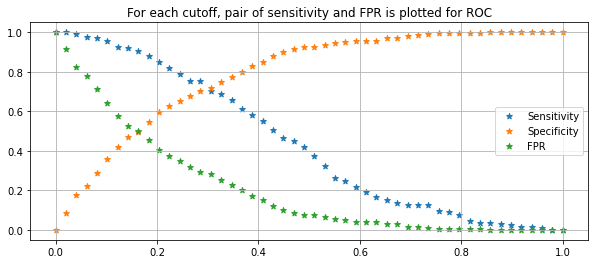

In [38]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [39]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [40]:
roc_like_df

cutoff  sensitivity  specificity     total
0  0.000000     1.000000     0.000000  1.000000
0  0.020408     1.000000     0.084270  1.084270
0  0.040816     0.992537     0.174157  1.166695
0  0.061224     0.977612     0.221910  1.199522
0  0.081633     0.970149     0.286517  1.256666
0  0.102041     0.955224     0.356742  1.311965
0  0.122449     0.925373     0.421348  1.346721
0  0.142857     0.917910     0.471910  1.389821
0  0.163265     0.902985     0.497191  1.400176
0  0.183673     0.880597     0.544944  1.425541
0  0.204082     0.850746     0.595506  1.446252
0  0.224490     0.820896     0.626404  1.447300
0  0.244898     0.791045     0.651685  1.442730
0  0.265306     0.753731     0.679775  1.433507
0  0.285714     0.753731     0.705056  1.458788
0  0.306122     0.701493     0.716292  1.417785
0  0.326531     0.686567     0.747191  1.433758
0  0.346939     0.656716     0.775281  1.431997
0  0.367347     0.611940     0.800562  1.412502
0  0.387755     0.582090     0.828652  1.410741
0  0.408163     0.552239     0.851124  1.403362
0  0.428571     0.507463     0.879213  1.386676
0  0.448980     0.462687     0.898876  1.361563
0  0.469388     0.447761     0.912921  1.360683
0  0.489796     0.417910     0.926966  1.344877
0  0.510204     0.373134     0.926966  1.300101
0  0.530612     0.320896     0.935393  1.256289
0  0.551020     0.261194     0.943820  1.205014
0  0.571429     0.246269     0.952247  1.198516
0  0.591837     0.216418     0.957865  1.174283
0  0.612245     0.194030     0.957865  1.151895
0  0.632653     0.164179     0.957865  1.122044
0  0.653061     0.149254     0.969101  1.118355
0  0.673469     0.134328     0.971910  1.106238
0  0.693878     0.126866     0.983146  1.110012
0  0.714286     0.126866     0.985955  1.112821
0  0.734694     0.126866     0.991573  1.118439
0  0.755102     0.097015     0.994382  1.091397
0  0.775510     0.089552     0.994382  1.083934
0  0.795918     0.074627     0.994382  1.069009
0  0.816327     0.044776     0.997191  1.041967
0  0.836735     0.037313     0.997191  1.034504
0  0.857143     0.037313     1.000000  1.037313
0  0.877551     0.029851     1.000000  1.029851
0  0.897959     0.022388     1.000000  1.022388
0  0.918367     0.014925     1.000000  1.014925
0  0.938776     0.014925     1.000000  1.014925
0  0.959184     0.007463     1.000000  1.007463
0  0.979592     0.000000     1.000000  1.000000
0  1.000000     0.000000     1.000000  1.000000

In [41]:
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

cutoff  sensitivity  specificity     total
0  0.285714     0.753731     0.705056  1.458788

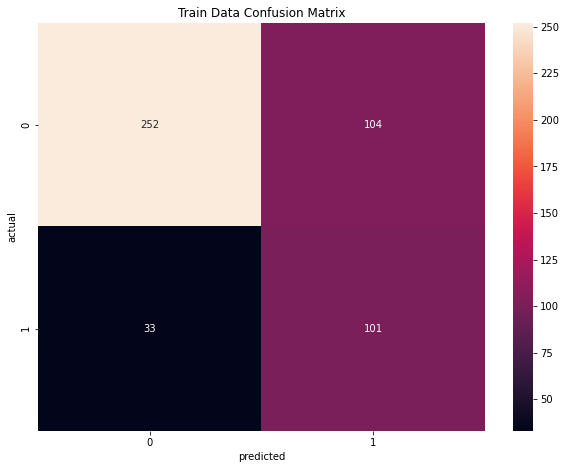

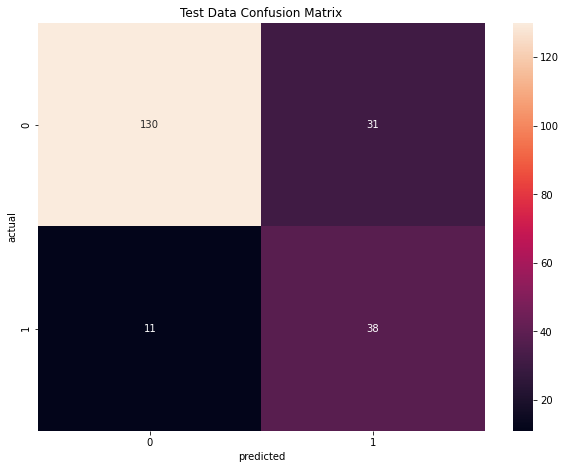

In [42]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.29 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

In [43]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.8
